# **XCEPTION TRANSFER LEARNING WITH DATA AUGMENTATION**



### **1. Import Libraries**

In [ ]:
import os
import pandas as pd

import xml.etree.ElementTree as ET
import time
import math
import cv2
import imageio
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as image
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from keras.utils import np_utils
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import decode_predictions
from sklearn.metrics import classification_report
import albumentations as A

###**2. Connect to Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###**3. Define paths and labels**

In [ ]:
#define original dataset path
image_path = '/content/drive/MyDrive/Project FindPet/dataset/FlickrDogDataset/original/Flickr-dog'
#define split dataset path
ds_path = '/content/drive/MyDrive/Project FindPet/dataset/FlickrDogDataset/dataAug/'
# Number of classes in the dataset
num_of_categories = 42
#Image size 
image_size = 299
# Batch size for training
batch_size = 8

In [ ]:
#list of breeds
breed_list = sorted(os.listdir(image_path))
#number of classes
num_classes = len(breed_list)
print("{} breeds".format(num_classes))

42 breeds


In [ ]:
# Define a time counter function to test the algorythms performance 
_start_time = time.time()

def process_time_starts():
    global _start_time 
    _start_time = time.time()

def time_elapsed():
    t_sec = round(time.time() - _start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print('The process took: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))

In [ ]:
#Define dictionary of labels
label_maps_rev = {}
for i, v in enumerate(breed_list):
    label_maps_rev.update({i : v})

###**4. Load train, validation and test dataset**

In [ ]:
# create a data generator
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# load and iterate training dataset
train_it = datagen.flow_from_directory(ds_path+'train/', class_mode='categorical', target_size=(299, 299), batch_size=8)
# load and iterate validation dataset
val_it = datagen.flow_from_directory(ds_path+'val/', class_mode='categorical', target_size=(299, 299), batch_size=8)
# load and iterate test dataset
test_it = datagen.flow_from_directory(ds_path+'test/', class_mode='categorical', target_size=(299, 299), batch_size=8)

Found 2437 images belonging to 42 classes.
Found 47 images belonging to 42 classes.
Found 90 images belonging to 42 classes.


###**5. Model Preparation**

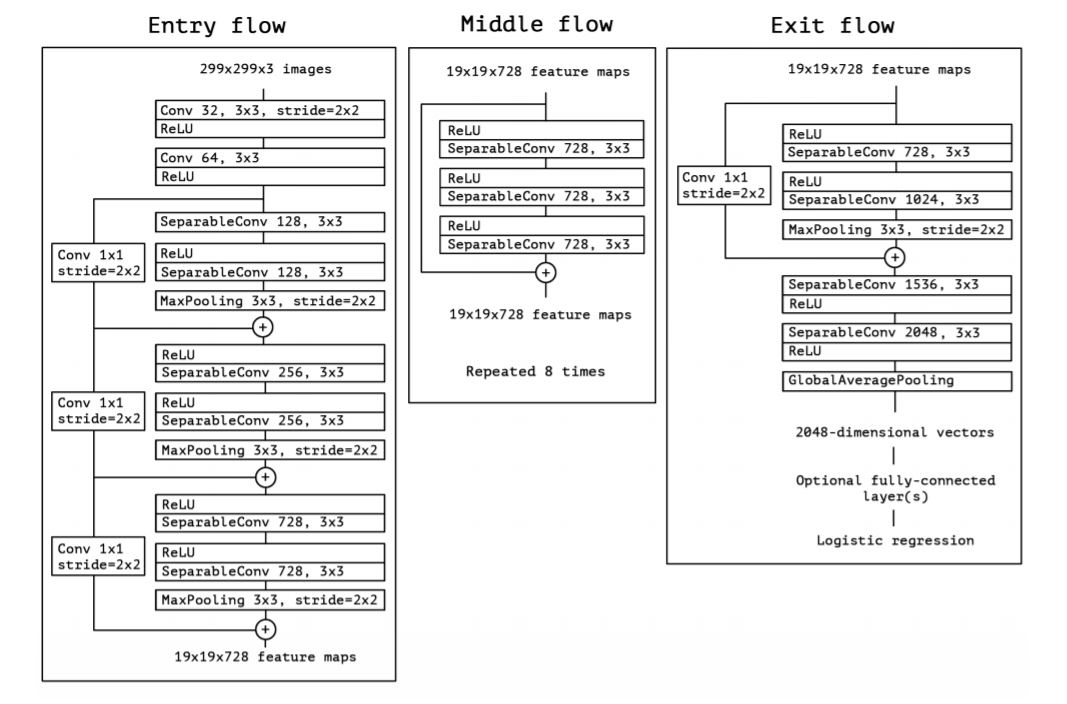

###**5.1.Importing the Xception CNN**

In [ ]:
#xception model using pre-trained weights of imagenet
#include_top is False to not include the fully connected layer on top of the network
base_model = tf.keras.applications.xception.Xception(weights='imagenet',include_top=False, pooling='avg')
#to only update the params of the new layers
base_model.trainable = False

###**5.2 Add Fully connected layers**

In [ ]:
flat_dim = 5 * 5 * 2048
# Create a `Sequential` model
my_model = Sequential(base_model)
#Add 3 Dense layers
my_model.add(Dense(1032, activation='relu',input_dim=flat_dim))
my_model.add(Dense(512, activation='relu'))
my_model.add(Dense(256, activation='relu'))
#Add Dense layer with softmax activation function
my_model.add(Dense(42, activation='softmax'))

###**5.3 Define callbacks and compile the model**

In [ ]:
###################
total_epoch = 60
learning_rate_init = 0.001
###################

In [ ]:
# Callbacks
#Path to save the best weights
checkpoint_filepath = '/content/drive/MyDrive/Project FindPet/dataset/FlickrDogDataset/da-best-weights.{epoch:02d}-{val_loss:.2f}.h5'
#Save the model weights each time an improvement is observed during training
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
#Define the optimizer
optimizer_ft = keras.optimizers.Adam(learning_rate=learning_rate_init)

In [ ]:
#Configures the model for training
my_model.compile(optimizer=optimizer_ft, loss='categorical_crossentropy', metrics=['accuracy'])


###**6. Training the model**



In [ ]:
process_time_starts()
#Train and evaluate
hist = my_model.fit_generator(generator=train_it, steps_per_epoch=40, validation_data=val_it,  validation_steps=3, epochs=60, callbacks=[model_checkpoint_callback])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/60
40/40 [==============================] - 9s 95ms/step - loss: 3.2808 - accuracy: 0.1031 - val_loss: 3.0464 - val_accuracy: 0.0833


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/60
40/40 [==============================] - 3s 76ms/step - loss: 2.5201 - accuracy: 0.2438 - val_loss: 2.6562 - val_accuracy: 0.2083
Epoch 3/60
40/40 [==============================] - 3s 76ms/step - loss: 2.1668 - accuracy: 0.3500 - val_loss: 2.0868 - val_accuracy: 0.5000
Epoch 4/60
40/40 [==============================] - 4s 90ms/step - loss: 1.8565 - accuracy: 0.4101 - val_loss: 2.0859 - val_accuracy: 0.3333
Epoch 5/60
40/40 [==============================] - 3s 79ms/step - loss: 1.6491 - accuracy: 0.4511 - val_loss: 1.4678 - val_accuracy: 0.5417
Epoch 6/60
40/40 [==============================] - 3s 77ms/step - loss: 1.3345 - accuracy: 0.5844 - val_loss: 1.5635 - val_accuracy: 0.5000
Epoch 7/60
40/40 [==============================] - 3s 78ms/step - loss: 1.3595 - accuracy: 0.5437 - val_loss: 1.5671 - val_accuracy: 0.4167
Epoch 8/60
40/40 [==============================] - 3s 81ms/step - loss: 1.2420 - accuracy: 0.5781 - val_loss: 1.3965 - val_accuracy: 0.5833
Epoch 9/60
40

In [ ]:
time_elapsed()

The process took: 0hour:4min:19sec


###**7. Loss and Accuracy Visualization**




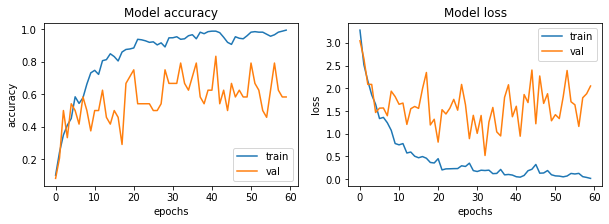

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])


###**8. Save model and parameters**

In [ ]:
my_model.save('/content/drive/MyDrive/Project FindPet/dataset/FlickrDogDataset/best_xception_with_da.h5', overwrite=True) 
my_model.save_weights('/content/drive/MyDrive/Project FindPet/dataset/FlickrDogDataset/best_xcept_weights_with-da.h5', overwrite=True)
print("Saved model to disk")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Saved model to disk


###**9. Test model accuracy**

In [ ]:
test_loss, test_accuracy = my_model.evaluate_generator(generator=test_it,steps=int(10))

print("Test results \n Loss:",test_loss,'\n Accuracy',test_accuracy)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test results 
 Loss: 1.571019172668457 
 Accuracy 0.675000011920929


###**10. Predict new images**

In [ ]:
def download_and_predict(url, filename):
    # download and save
    os.system("curl -s {} -o {}".format(url, filename))
    img = Image.open(filename)
    img = img.convert('RGB')
    img = img.resize((299, 299))
    img.save(filename)
    # show image
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    # predict
    img = image.imread(filename)
    img = preprocess_input(img)
    probs = my_model.predict(np.expand_dims(img, axis=0))
    for idx in probs.argsort()[0][::-1][:5]:
        print("{:.2f}%".format(probs[0][idx]*100), "\t", label_maps_rev[idx].split("-")[-1])

100.00% 	 Lulu
0.00% 	 Skipper
0.00% 	 Kappel
0.00% 	 Newton
0.00% 	 Zowie


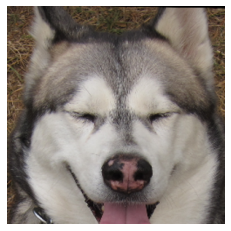

In [ ]:
download_and_predict("https://i.ibb.co/9gsDrYZ/Lulu-01-crp.png",
                     "test_2.jpg")